## Merge daily images
The output from planetlabs is several different rasters as the area of interest will be over multiple images. This is due to how the imagery was taken. The images must be combined together through the process of merge.


In [23]:
import os
import rasterio
from rasterio.merge import merge
from shapely.geometry import mapping, Polygon, Point
from rasterio import features
import fiona
from fiona.crs import from_epsg
from osgeo import gdal
import ogr, osr
from osgeo import ogr
import csv
import geojson
import json
import pandas
from rasterstats import raster_stats
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score,confusion_matrix, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tsraster.model  as md
import pandas as pd
from rasterio.warp import calculate_default_transform, reproject, Resampling
from tsraster.calculate import calculateFeatures
import seaborn as sb
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
inpath = "../Imagery/"

In [ ]:
# Merge function. Two inputs, the path where the file will be saved and the files that will be merged
def merge_rast(outpath, inpath):
    files_mosaic = []
    
    # Opens the files to be merged
    for file in q:
        src = rasterio.open(file)
        files_mosaic.append(src)
    
    # Sets the files up to be merged
    mosaic, out_trans = merge(files_mosaic)
    
    # Creates the metadata for the files
    out_meta = src.meta.copy()

    # Writes out the merged raster with the above metadata and a unique name
    with rasterio.open(outpath, "w", **out_meta) as dest:
        dest.write(mosaic)

# Function to select files to be merged. Goes through a folder and writes out a list of unique names
# Uses the unique names to then select appropriate files
def compare():
    ending_list = []
    
    # Selects the first part of the file names (ie. MMDDYY)
    for root, dirs, files in os.walk(inpath):
        for filename in files:
            if filename.endswith(".tif"):
                print('File name is: {0}'.format(filename))
                ending_list.append(filename.split('_',1)[0])
    
    # Creates a unique list of the selected names above to iterate through
    unique_ending = list(set(ending_list))

    # Iterates through the unique list to select where files contain the same name and sets them up to be merged
    for unique in unique_ending:
        for root, dirs, files in os.walk(inpath):
            for filename in files:
                if filename.startswith(unique):
                    files_unique = [x for x in files if x.startswith(unique)]
                    outpath = q + unique + "_merge.tif"
                    if unique != False:
                        os.chdir(q)
                        merge_rast(outpath, files_unique)
                 

compare()


## Create BAI index


In [13]:
# Function to calculate the Burn Area Index for each raster
def bai_rast(inpath, outpath):
    
    # Opens the raster for the calculation
    with rasterio.open(inpath) as src:
        brn_data = src.read()
       
    # BAI Formula
    brn_bai = (1 / ((.1-brn_data[2])**2)+((.06-brn_data[3])**2))
    
    # Sets up the metadata for the output raster
    with rasterio.open(inpath) as src:
        brn_data_ras = src.read()
        brn_meta = src.profile

    brn_transform = brn_meta["transform"]
    brn_crs = brn_meta["crs"]
    brn_meta['count'] = 1
    brn_meta['dtype'] = 'float64'

    # Saves out the raster according to the below criteria
    with rasterio.open(outpath, 'w', **brn_meta) as dst:
        dst.write(brn_bai, 1)

# Function to select files to calculate the BAI on
def compare():
    ending_list = []
    for root, dirs, files in os.walk(inpath):
        for filename in files:
            if filename.endswith("merge.tif"):
                print('File name is: {0}'.format(filename))
                ending_list.append(filename.split('_',1)[0])

    unique_ending = list(set(ending_list))
    unique2 = unique_ending
    
    # Selects the files using a unique identifier and sets up the out paths
    for unique in unique_ending:
        for root, dirs, files in os.walk(inpath):
            for filename in files:
                if filename.startswith(unique):
                    files_unique = [x for x in files if x.startswith(unique)]
                    file_paths = [x for x in files_unique if x.endswith("merge.tif")]
                    outpath = inpath + unique + "_bai.tif"
                    if unique != False:
                        os.chdir(inpath)
                        bai_rast(file_paths[0], outpath)
               

compare()

File name is: 20181005_merge.tif
File name is: 20181016_merge.tif
File name is: 20181116_merge.tif


## Create blank example raster


In [16]:
# Function that merges all the bai rasters as preparation for creating the point grid
def merge_all_rast(outpath, inpath):
    # Blank list to be appended to
    files_mosaic = []
    
    # For loop to access all files that meet the criteria of ending in "bai.tif"
    for file in inpath:
        src = rasterio.open(file)
        files_mosaic.append(src)
    
    # Merge function for the files set to the above list
    mosaic, out_trans = merge(files_mosaic)
    
    # Collects the metadata of the original bai rasters
    out_meta = src.meta.copy()
    
    # Writes out the merged raster
    with rasterio.open(outpath, "w", **out_meta) as dest:
        dest.write(mosaic)
        
# Selects the files using a unique identifier and sets up the out paths

ending_list = []
for root, dirs, files in os.walk(inpath):
    for filename in files:
        if filename.endswith("bai.tif"):
            print('File name is: {0}'.format(filename))
            ending_list.append(filename)
            outpath = inpath + "all_merge.tif"
            os.chdir(inpath)
            merge_all_rast(outpath, ending_list)
        

File name is: 20181005_bai.tif
File name is: 20181016_bai.tif
File name is: 20181116_bai.tif


In [6]:
for root, dirs, files in os.walk(inpath):
    for filename in files:
        print(filename)

20181005_050613_clip_AnalyticMS_SR.tif
20181005_050614_clip_AnalyticMS_SR.tif
20181005_merge.tif
20181016_050544_clip_AnalyticMS_SR.tif
20181016_050545_clip_AnalyticMS_SR.tif
20181016_merge.tif
20181116_045359_clip_AnalyticMS_SR.tif
20181116_merge.tif


In [18]:
# Outpath for the vect_shape function
outpath1 = os.path.join(inpath + "vect_shape.shp")

# Function to vectorize the merged raster from the merge_all_rast() function
def vect_shape(outpath, inpath):
    merge = os.path.join(inpath + "all_merge.tif")
    
    # Opens the merged raster and collects the bounds of the image
    raster = rasterio.open(merge)
    raster_bounds = tuple(raster.bounds)


    # define the lower and upper limits for x and y
    minX, maxX, minY, maxY = raster_bounds[0], raster_bounds[1], raster_bounds[2], raster_bounds[3]
    # create one-dimensional arrays for x and y

    print(raster_bounds)

    top_left = [minX, maxY]
    top_right= [minY, maxY]
    bottom_left = [minX, maxX]
    bottom_right = [minY, maxX]
    
    # Takes the above coordinates from the bounds and sets them as the new shapefile's bounds
    coords = [[top_left], [bottom_left], [top_right], [bottom_right]]

    poly = Polygon([top_left, top_right, bottom_right, bottom_left])
    
    # Schema necessary to write out the shapefile as a polygon
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }
    
    # Writes the shapefile out as 4326 with the above criteria
    with fiona.open(outpath, 'w', crs=from_epsg(32643), driver ='ESRI Shapefile', schema = schema) as c:
        ## If there are multiple geometries, put the "for" loop here
        c.write({
            'geometry': mapping(poly),
            'properties': {'id': 123},
        })
vect_shape(outpath1, inpath)

# Outpath for the blank_rast function 
outpath2 = os.path.join(inpath + "blank_rast.tif")

# Function to create a blank raster from the shapefile created above
def blank_rast(outpath, inpath):
    vector_file = os.path.join(inpath + "vect_shape.shp")
    
    # Opens the vectorized merge file to create the blank raster
    shapefile = fiona.open(vector_file)
    geom = [shapes['geometry'] for shapes in shapefile]
    attrib = [shapes['properties'] for shapes in shapefile]


    #get metadata for satellite imagery
    merge = os.path.join(inpath + "all_merge.tif")
    rst = rasterio.open(merge)
    
    # Rasterizes the shapefile
    image = features.rasterize(geom, out_shape=rst.shape, transform=rst.transform, dtype = 'float64')
    
    # Writes out the new blank raster
    with rasterio.open(
            outpath , 'w',
            driver='GTiff',
            transform = rst.transform,
            dtype= 'float64',
            crs= 'EPSG:32643',
            count=1,
            width=rst.width,
            height=rst.height) as dst:
        dst.write(image, indexes=1)
blank_rast(outpath2, inpath)

(633575.081842361, 3307089.7988889534, 634458.1690485424, 3308309.4637285504)


## Reproject and Resample
Make all images the same projection and extent of the empty raster

In [48]:
# A funciton that reprojects the rasters to match blank raster properties 
def reproject_rast(outpath, inpath):
    
    # Desired CRS (wgs84 UTM zone 43N)
    dst_crs = 'EPSG:32643'  

    # opens blank raster and copies properties 
    with rasterio.open( 'blank_rast.tif') as example:
        example.kwargs = example.meta.copy()
    
    # Opens the raster to be reprojected
    with rasterio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': example.kwargs['width'],
            'height': example.kwargs['height']
        })
        
        # Reprojects the raster
        with rasterio.open(outpath, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)

# Function to search through folders to select files to be reprojected
def compare():
    ending_list = []
    
    # Searches for files that end with merge.tif and sets them to a new list
    for root, dirs, files in os.walk(inpath):
        for filename in files:
            if filename.endswith("bai.tif"):
                print('File name is: {0}'.format(filename))
                ending_list.append(filename.split('_',1)[0])
    
    # Creates a unique list from above
    unique_ending = list(set(ending_list))

    # Searches through the unique list to select files that are unique and contain the words merge
    for unique in unique_ending:
        for root, dirs, files in os.walk(inpath):
            for filename in files:
                if filename.startswith(unique):
                    files_unique = [x for x in files if x.startswith(unique)]
                    files_path = [x for x in files_unique if x.endswith("bai.tif")]
                    outpath = inpath + unique + "_bai_reproj.tif"
                    if unique != False:
                        os.chdir(inpath)
                        reproject_rast(outpath, files_path[0])

compare()

File name is: 20181005_bai.tif
File name is: 20181016_bai.tif
File name is: 20181116_bai.tif


## Extract Statistics and Classification

Moved the final data to a new folder and renamed them baireproject_2018105.tif etc... 

In [4]:
#directory
path = "../Imagery/Cleaned/"

parameters = {
        "mean": None,
        "maximum": None,
        "median":None,
        "minimum":None,
        "mean_abs_change":None,
        "mean_change":None,
        "sum_values":None,
        "standard_deviation":None
    }

In [5]:
ts_features = calculateFeatures(path=path, 
                                parameters=parameters, 
                                reset_df=True, 
                                tiff_output=False,
                                   )

df: ../Imagery/Cleaned/my_df.csv


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.22s/it]


features:..\Imagery\Cleaned_features\extracted_features.csv


In [6]:
ts_features.head()


,variable,baireproj__maximum,baireproj__mean,baireproj__mean_abs_change,baireproj__mean_change,baireproj__median,baireproj__minimum,baireproj__standard_deviation,baireproj__sum_values
pixel_id,time,,,,,,,,
0,20181005_20181116,100.003601,100.003601,0.0,0.0,100.003601,100.003601,0.0,300.010803
1,20181005_20181116,100.003601,100.003601,0.0,0.0,100.003601,100.003601,0.0,300.010803
2,20181005_20181116,100.003601,100.003601,0.0,0.0,100.003601,100.003601,0.0,300.010803
3,20181005_20181116,100.003601,100.003601,0.0,0.0,100.003601,100.003601,0.0,300.010803
4,20181005_20181116,100.003601,100.003601,0.0,0.0,100.003601,100.003601,0.0,300.010803


In [7]:
ts_features.describe()

variable,baireproj__maximum,baireproj__mean,baireproj__mean_abs_change,baireproj__mean_change,baireproj__median,baireproj__minimum,baireproj__standard_deviation,baireproj__sum_values
count,1.196580e+05,1.196580e+05,1.196580e+05,1.196580e+05,1.196580e+05,1.196580e+05,1.196580e+05,1.196580e+05
mean,9.937589e+06,6.810837e+06,3.439601e+06,-2.009424e+06,6.635406e+06,3.859514e+06,2.641112e+06,2.043251e+07
std,2.511109e+06,1.543344e+06,1.791976e+06,2.159473e+06,2.330068e+06,1.323126e+06,1.144705e+06,4.630032e+06
min,1.000036e+02,1.000036e+02,0.000000e+00,-7.732684e+06,1.000036e+02,1.000036e+02,0.000000e+00,3.000108e+02
25%,8.608004e+06,5.874342e+06,2.382346e+06,-3.238375e+06,4.682636e+06,3.093870e+06,1.987154e+06,1.762303e+07
50%,9.684171e+06,6.784989e+06,3.125462e+06,-2.490711e+06,6.553293e+06,3.587009e+06,2.543638e+06,2.035497e+07
75%,1.096232e+07,7.715505e+06,4.089568e+06,-1.371758e+06,8.421256e+06,4.372030e+06,3.210396e+06,2.314652e+07
max,2.006090e+07,1.375215e+07,1.206887e+07,7.942538e+06,1.433334e+07,1.263049e+07,7.431950e+06,4.125644e+07


C:\Users\mmann\AppData\Local\Continuum\anaconda3\envs\ts-raster\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


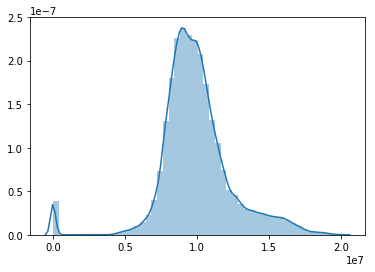

In [8]:
sb.distplot(ts_features.baireproj__maximum.values)

 ## Example unsupervised classification
 

In [48]:
# fit model
kmeans = KMeans(n_clusters=6, random_state=0).fit(ts_features)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [49]:
# make predictions of classes to original data
class_preds = kmeans.predict(ts_features)

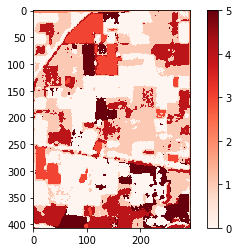

In [50]:
# convert classification  back to raster 

raster_ex = "../Imagery/Cleaned/baireproj-20181005.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = class_preds.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

## KEEP IN MIND THAT 1 DOESN'T MEAN BURNED... COULD BE UNBURNED 


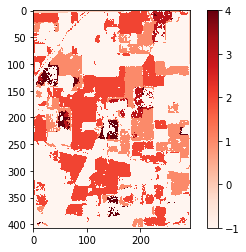

In [44]:
# center and scale
ts_features_scale = StandardScaler().fit_transform(ts_features)

# fit model
db = DBSCAN(eps=0.4, min_samples=1000).fit(ts_features_scale)
class_preds =db.labels_

raster_ex = "../Imagery/Cleaned/baireproj-20181005.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = class_preds.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

## Example supervised classification
In this example I will make up an example training dataset and run the classifier on it. 

In [52]:
ts_features['Burned']=0
ts_features.loc[(ts_features.baireproj__maximum > 0.8e7) &
                (ts_features.baireproj__mean_change > 0) ,'Burned'] = 1
# isolate dependent variable and remove from independent variables
Burned = ts_features['Burned']
ts_features.drop(columns=['Burned'],inplace=True)
# print(Burned.head())
# print(ts_features.head())

In [53]:
obj = [Burned,ts_features]

X_train, X_test, y_train, y_test = md.get_data(obj,
                                            stratify=True,
                                            test_size=0.9,
                                            scale=False  )

input should be csv or pandas dataframe with yX, or [y,X]
reading in list concat on common index, inner join


In [54]:
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,
                                 max_depth=2, random_state=0).fit(X_train, y_train)


In [55]:
predict_test = clf.predict(X=X_test)

test_acc = accuracy_score(y_test, predict_test)
kappa = cohen_kappa_score(y_test, predict_test)
confusion = confusion_matrix(y_test, predict_test)

print('Testing accuracy:',test_acc)
print('Testing Kappa: ',kappa)
print('Testing Conf: ')
print(confusion)

Testing accuracy: 0.9999071434540778
Testing Kappa:  0.9995603042470054
Testing Conf: 
[[94766     0]
 [   10 12917]]


In [56]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_test.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
 
feature_importances

,importance
baireproj__mean_change,0.883521
baireproj__maximum,0.116479
baireproj__mean,0.000000
baireproj__mean_abs_change,0.000000
baireproj__median,0.000000
baireproj__minimum,0.000000
baireproj__standard_deviation,0.000000
baireproj__sum_values,0.000000


Make predictions back to the full original dataset

In [57]:
# make prediction of class
all_predict = md.model_predict(model = clf,
                                        new_X = ts_features)

# returns probability of each class
all_prob =  md.model_predict_prob(model = clf,
                                        new_X = ts_features)
print(all_predict.head())
print(all_prob.head())

pixel_id  time             
0         20181005_20181116    0
1         20181005_20181116    0
2         20181005_20181116    0
3         20181005_20181116    0
4         20181005_20181116    0
dtype: int64
                                   0         1
pixel_id time                                 
0        20181005_20181116  0.999887  0.000113
1        20181005_20181116  0.999887  0.000113
2        20181005_20181116  0.999887  0.000113
3        20181005_20181116  0.999887  0.000113
4        20181005_20181116  0.999887  0.000113


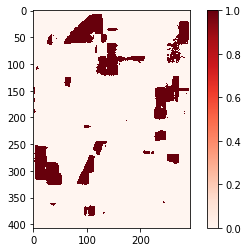

In [58]:
# convert classification  back to raster 

raster_ex = "../Imagery/Cleaned/baireproj-20181005.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = all_predict.values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

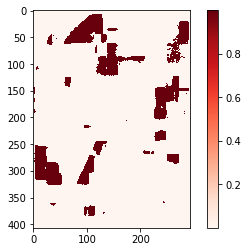

In [59]:
# convert classification PROBABILITY back to raster 

raster_ex = "../Imagery/Cleaned/baireproj-20181005.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = all_prob[1].values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()